In [10]:
from Map import Point, Segment, Graph, Stop, Route
from Compute import get_closest_segment_np
from matplotlib import pyplot as plt
import pandas as pd
import pymongo
from datetime import datetime
import math
import numpy as np
from numba import jit
import geojson

In [2]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

mydb = myclient["tu-around"]
mycol = mydb["gpslogs"]

In [3]:
myquery = { "carno": "0TU0001 (1B)",
           "acctime": { "$gte": datetime(2019,11,19, 3, 43, 0),
                       "$lt": datetime(2019, 11, 19, 4, 10, 0)} }
myselector = { "_id": 0, "lat": 1, "lon": 1, "timestamp": 1,
              "acctime": 1, "speed": 1, "direction": 1
             }
mydoc = mycol.find(myquery, myselector)
gps_log =  pd.DataFrame(list(mydoc))
# remove 0 speed
gps_log = gps_log[gps_log['speed'] > 0]

In [4]:
with open('qgis-path/road-edit.geojson', 'r', encoding='UTF8') as f:
    with open('qgis-path/road-edit_temp.geojson', 'w', encoding='UTF8')  as w:
        for line in f:
            if "null" in line:
                continue
            w.write(line)

In [21]:
global road
with open('qgis-path/road-edit_temp.geojson', 'r', encoding="UTF8") as f:
    road = geojson.loads("".join(f.readlines()))
    
G = Graph()
for feature in road['features']:
#     stop
    if feature['geometry']['type'] != "LineString":
        continue
    tid = feature['id']
    coordinates =  feature['geometry']['coordinates']
    
    ps = G.add_point( f"p_{tid}_0",
                coordinates[0][0],
                coordinates[0][1]
              )
    pe = G.add_point( f"p_{tid}_{len(coordinates) - 1}",
                coordinates[-1][0], 
                coordinates[-1][1]
              )
        
    for i in range(len(coordinates) - 1):
        pe = G.add_point(f"p_{tid}_{i + 1}",
                         coordinates[i + 1][0],
                         coordinates[i + 1][1]
                        )
        s = G.add_segment(f's_{tid}_f_{i + 1}', ps, pe)
        s_b = G.add_segment(f's_{tid}_b_{i + 1}', pe, ps)
        ps = pe

In [24]:
route_1_df = pd.read_csv('route-1 - Copy.csv')
ngv_1 = Route('ngv-1')
ngv_1.set_graph(G)

for index, way in route_1_df.iterrows():
    ngv_1.add_way(way['from'], way['to'], way['stop'],  way['dist'])
ngv_1

In [87]:
from datetime import datetime
initial_speed = 20
count = 1
sample_freq = 60 // 5
a = np.array((20,  1) * 12 * 24 * 7).reshape(7, 24, 12, 2)

In [91]:
%%timeit
d = datetime.now()
weekday = d.weekday()
hr = d.hour
minute = d.minute // 5
a[weekday][hr][minute] =[34, 2]

2.35 µs ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


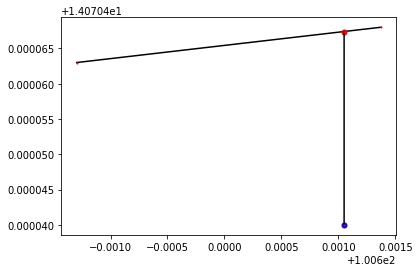

In [43]:
segment_df = G.get_segment_df()
gps = gps_log.iloc[120]
sid = get_closest_segment_np(segment_df, gps.lon, gps.lat, gps.direction, 20)

segment = G.get_segment_by_id(sid)
p = Point('', gps.lon, gps.lat)
segment.draw()
p.draw('bo', 5)
p2 = segment.match(p)
p2.draw('ro', 5)
Segment('', p, p2).draw()

fail match
fail match
fail match
fail match


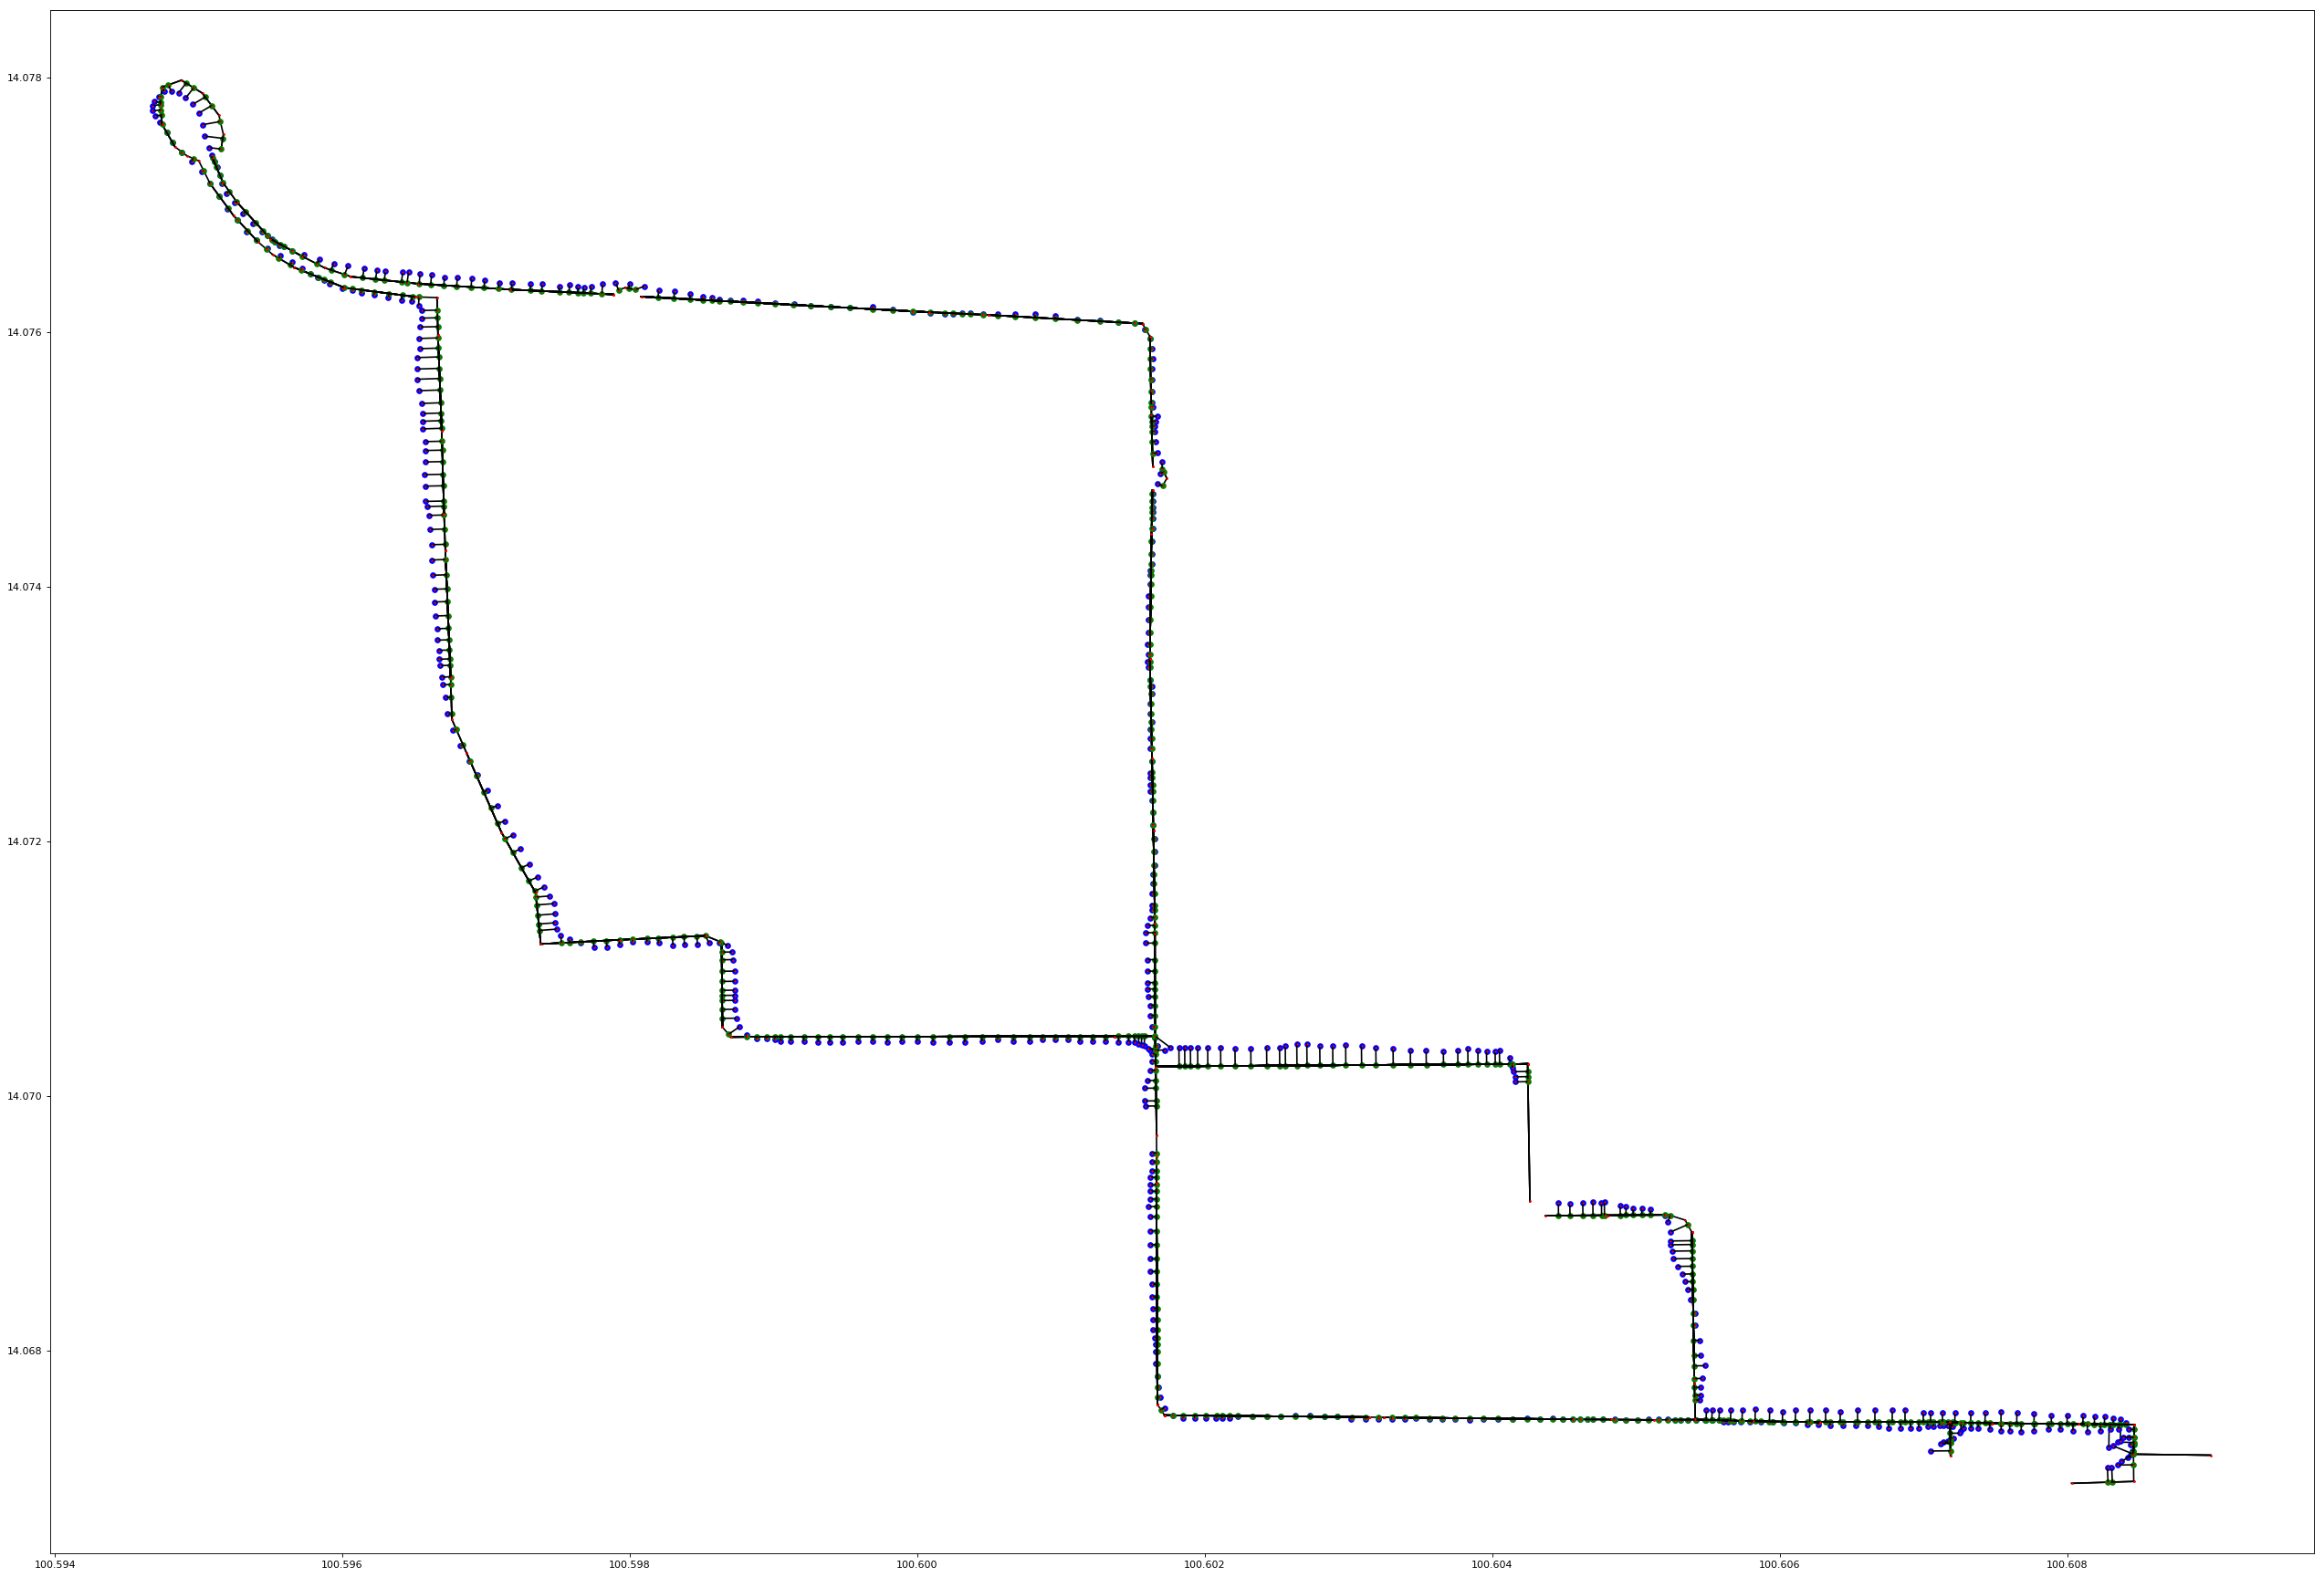

In [42]:
fig, ax = plt.subplots(figsize = (40,28), dpi= 80)
segment_df = G.get_segment_df()

for i, gps in gps_log.iterrows():
# # # %%timeit
    
    sid = get_closest_segment_np(segment_df, gps.lon, gps.lat, gps.direction, 20)
    if not sid: continue
    segment = G.get_segment_by_id(sid)
    p = Point('', gps.lon, gps.lat)
    segment.draw()
    p.draw('bo', 5)
    p2 = segment.match(p)
    p2.draw('go', 5)
    Segment('', p, p2).draw()

# print(len(c))

s_way/228788194_b_5
s_way/228788194_b_4
s_way/228788194_b_3
s_way/228788194_b_2
s_way/228788194_b_1
s_way/228788193_b_6
s_way/228788193_b_5
s_way/228788193_b_4
s_way/228788193_b_3
s_way/228788193_b_2
s_way/228788193_b_1
s_way/378474719_f_1
s_way/378474719_f_2
s_way/378474719_f_3
s_way/378474719_f_4
s_way/378474719_f_5
s_way/378474719_f_6
s_way/62274156_f_1
s_way/62274156_f_2
s_way/62274156_f_3
s_way/62274156_f_4
s_way/62274156_f_5
s_way/62274156_f_6
s_way/62274156_f_7
s_way/694594557_b_10
s_way/694594557_b_9
s_way/694594557_b_8
s_way/694594557_b_7
s_way/694594557_b_6
s_way/694594557_b_5
s_way/694594557_b_4
s_way/694594557_b_3
s_way/694594557_b_2
s_way/694594557_b_1
s_way/754267302_f_1
s_way/754267302_f_2
s_way/754267302_f_3
s_way/754267302_f_4
s_way/754267302_f_5
s_way/738335733_f_1
s_way/738335733_f_2
s_way/738335733_f_3
s_way/62353167_f_2
s_way/62353167_f_3
s_way/62353167_f_4
s_way/62353167_f_5
s_way/62353167_f_6
s_way/62353167_f_7
s_way/62353167_f_8
s_way/62353167_f_9
s_way/62353167

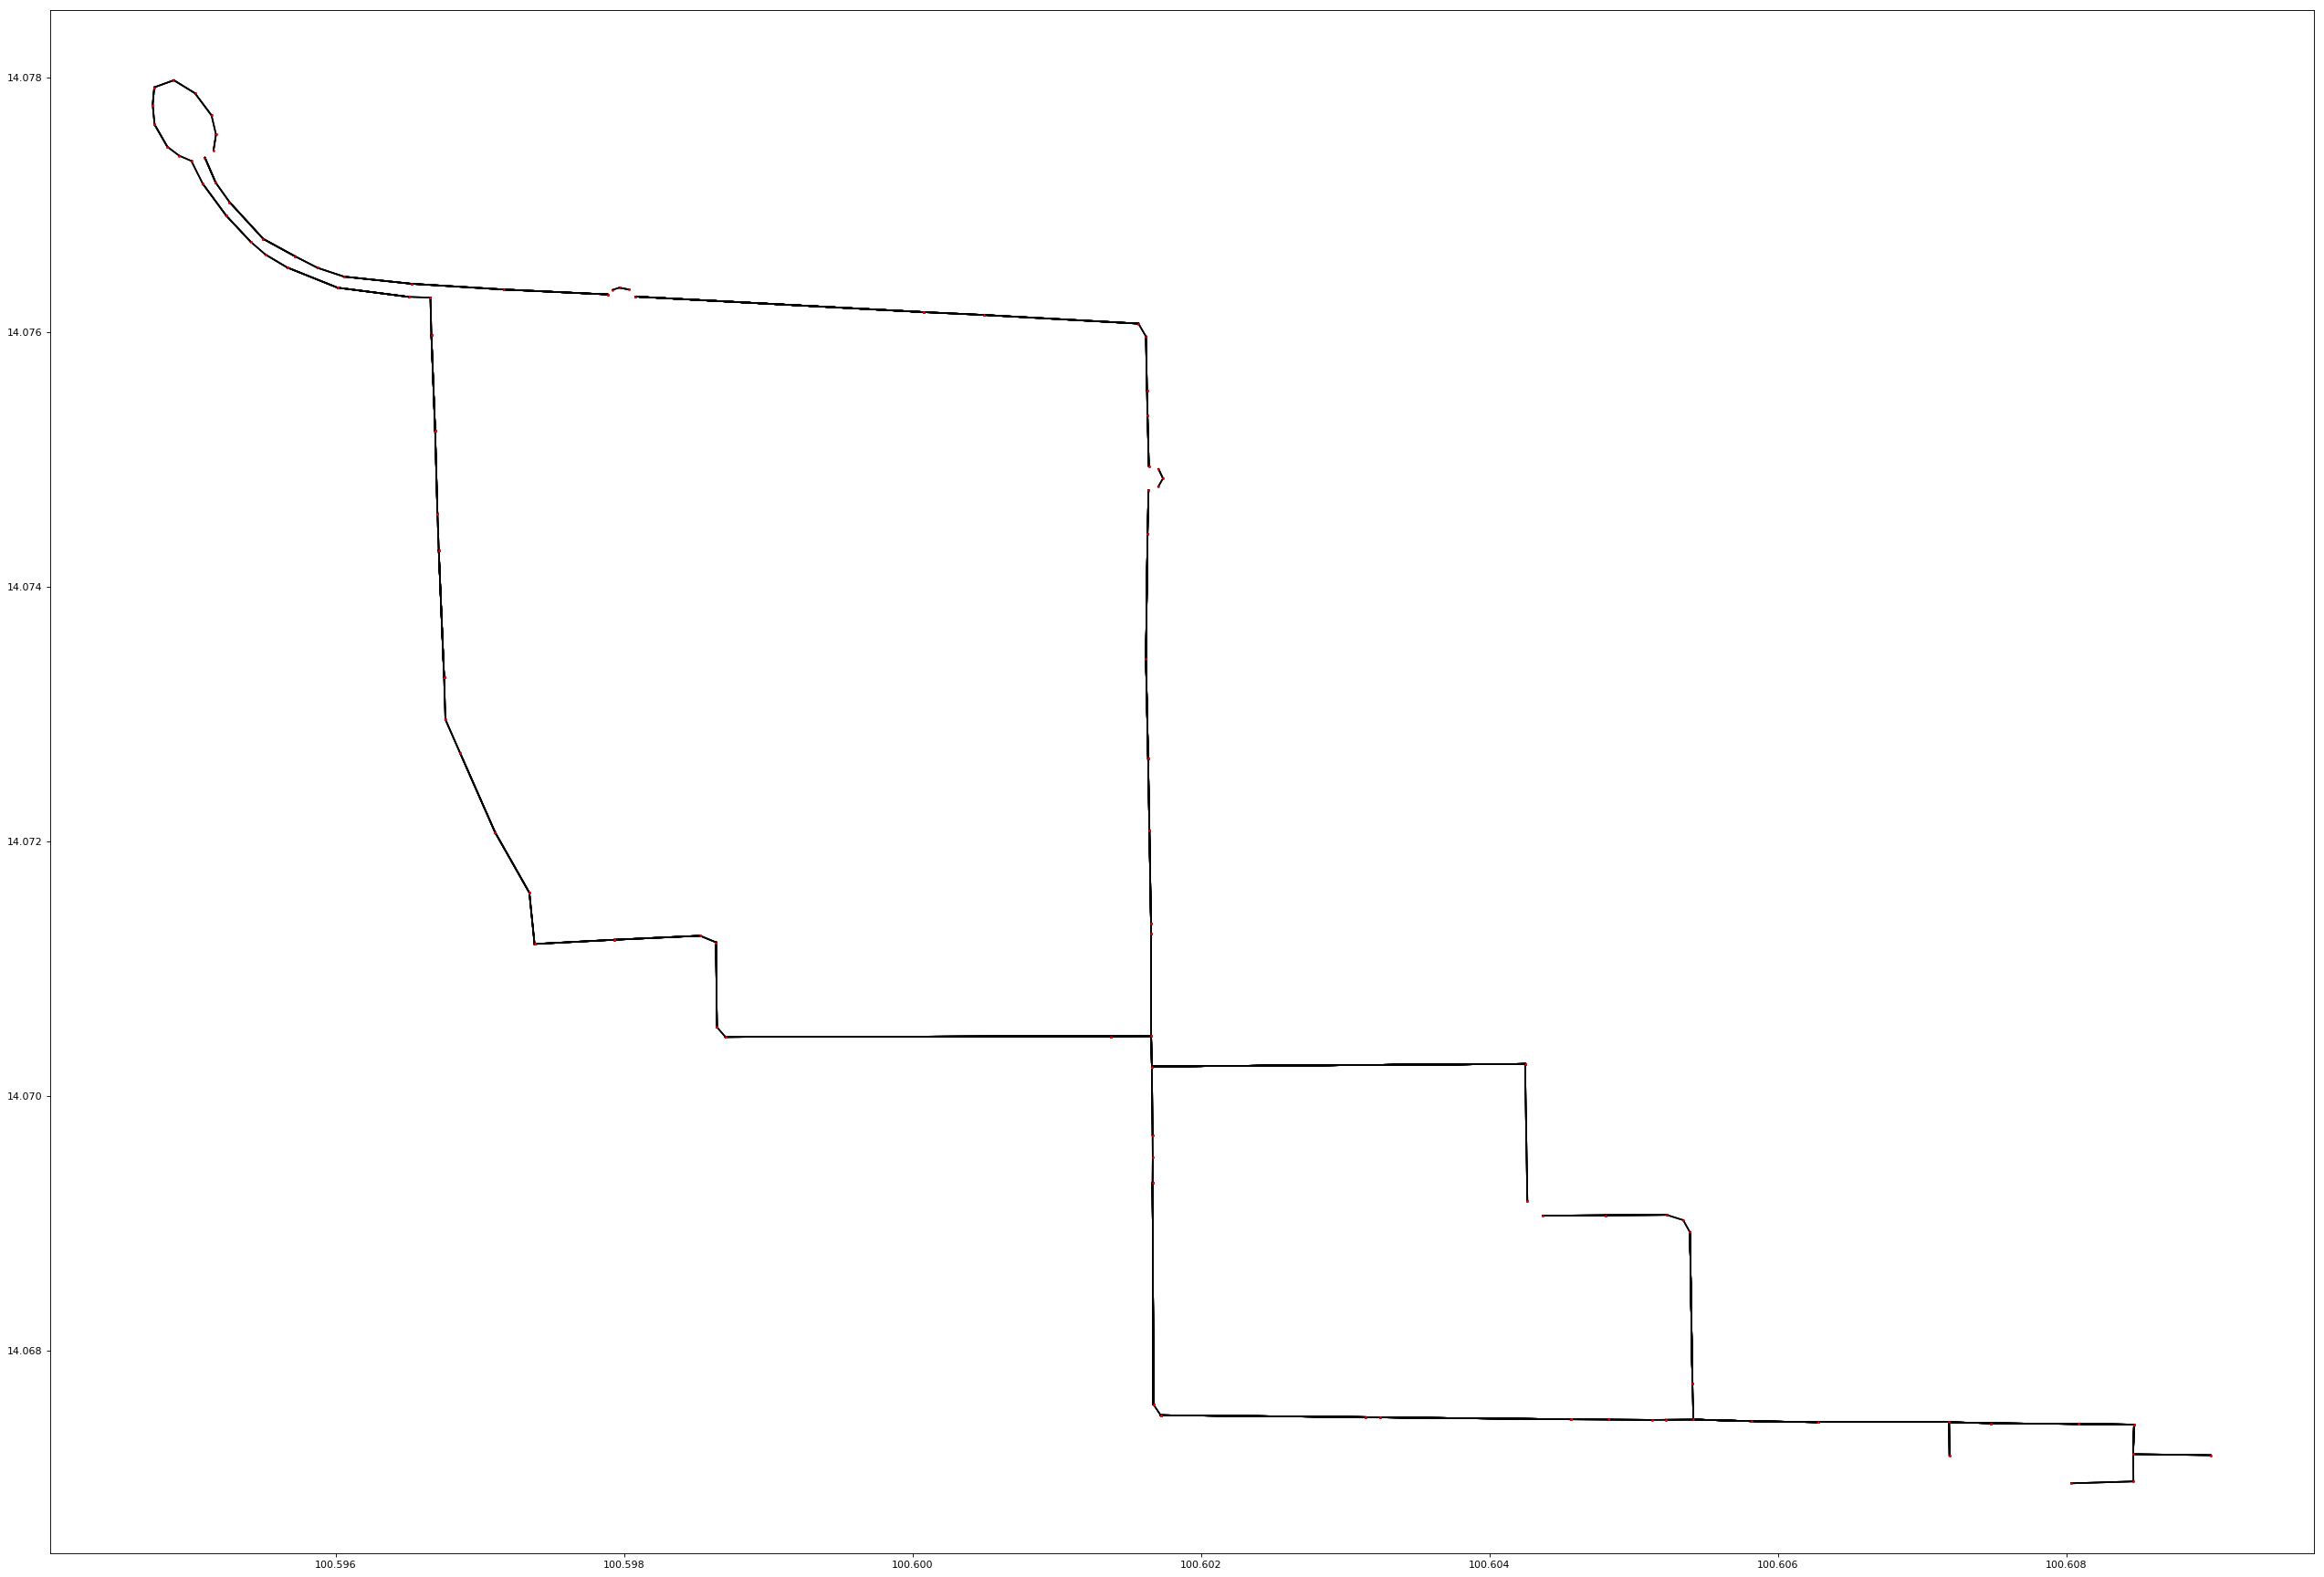

In [11]:
prev = ''
plt.subplots(figsize = (40,28), dpi= 80)
for sid in s_l:
    if sid != prev:
        print(sid)
        G.get_segment_by_id(sid).draw()
        prev = sid
    G.get_segment_by_id(sid).draw()
    

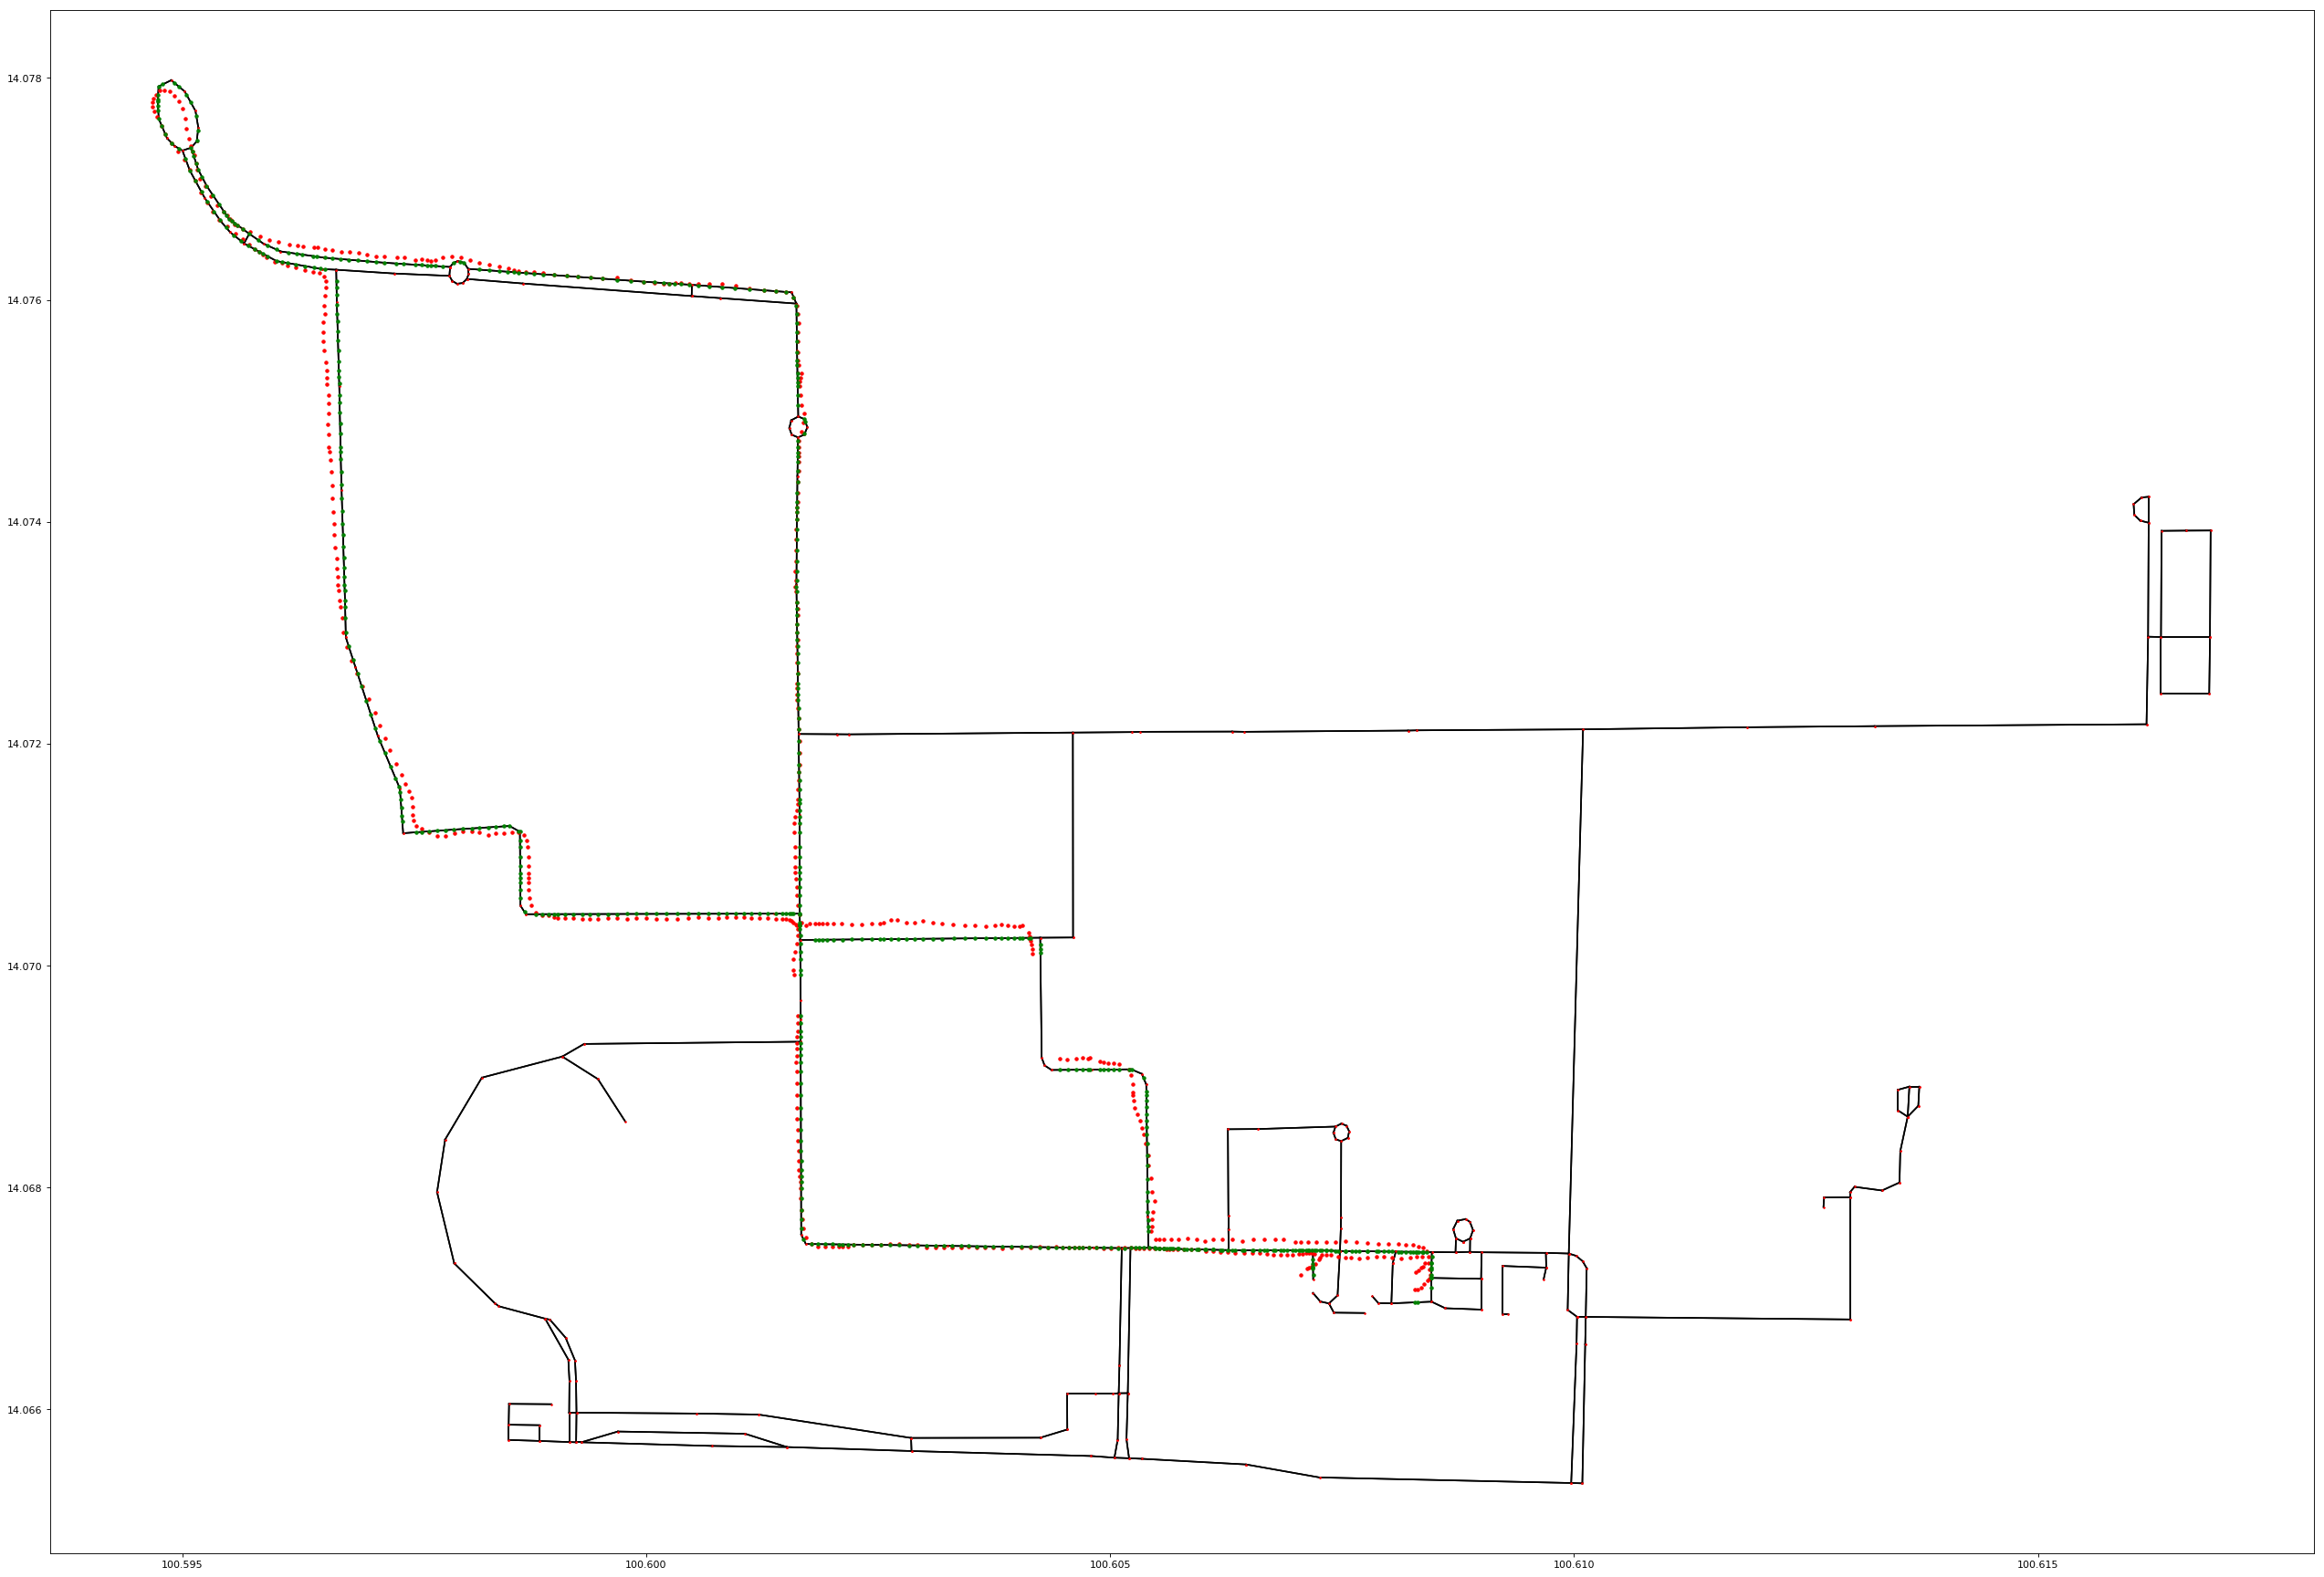

In [14]:

BBox = (100.59466123580931, 100.6096762418747, 14.0657426, 14.077905553749266)


fig, ax = plt.subplots(figsize = (40,28), dpi= 80)

for sid in G.segments:
    G.segments[sid].draw()
# for gid, gps in gps_log.iloc[499:501].iterrows():
# plt.plot(gps['lon'], gps['lat'], "bo", markersize=5)

# tid, segment, dist = c
# segment.ps.draw('go')
# segment.pe.draw('go')
# segment.match(p).draw('bo')
# segment.draw('r')

for match_p, gps_p in gc:
    gps_p.draw('ro', markersize=3)
    match_p.draw('go', markersize=3)
    
# traj = G.get_trajectory_by_id('way/228788194_b')
# traj.ps.draw('bo')
# traj.pe.draw('bo')
# for segment in traj.S:
#     segment.draw('b-')
    